
# 📊 Offline Search Evaluation on Amazon ESCI

This notebook implements an **offline evaluation prototype** for e-commerce search using the **Amazon ESCI** dataset.
- Dataset: [amazon-science/esci-data](https://github.com/amazon-science/esci-data)
- Algorithms: BM25 (keyword-based) and SBERT+FAISS (semantic)
- Metrics: nDCG@K, MAP@K, MRR, Precision/Recall@K


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Install dependencies
%%capture
!pip -q install pandas numpy scikit-learn rank_bm25 sentence-transformers faiss-cpu matplotlib tqdm

In [ ]:
import os, random, math
import numpy as np, pandas as pd
from tqdm import tqdm
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
import faiss
import matplotlib.pyplot as plt
from collections import defaultdict
from math import log2
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from scipy import stats

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
import pandas as pd
df_examples = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Datasets/amazon_esci/shopping_queries_dataset_examples.parquet')
df_products = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Datasets/amazon_esci/shopping_queries_dataset_products.parquet')

for c in ["product_title","product_bullet_point","product_brand"]:
    if c in df_products.columns:
        df_products[c] = df_products[c].fillna("").astype(str)
df_products["doc_text"] = df_products[["product_title","product_bullet_point","product_brand"]].agg(" ".join, axis=1)
df_products = df_products[["product_id","doc_text", "product_locale"]].drop_duplicates()

df_examples_products = pd.merge(
    df_examples,
    df_products,
    how='left',
    left_on=['product_locale','product_id'],
    right_on=['product_locale', 'product_id']
)
df_task_1 = df_examples_products[df_examples_products["small_version"] == 1]
df_task_1 = df_task_1[df_task_1["product_locale"] == "us"]
df_task_1.head(n=30)

,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split,doc_text
16,16,!awnmower tires without rims,1,B075SCHMPY,us,I,1,1,train,"RamPro 10"" All Purpose Utility Air Tires/Wheel..."
17,17,!awnmower tires without rims,1,B08L3B9B9P,us,E,1,1,train,MaxAuto 2-Pack 13x5.00-6 2PLY Turf Mower Tract...
18,18,!awnmower tires without rims,1,B082K7V2GZ,us,I,1,1,train,NEIKO 20601A 14.5 inch Steel Tire Spoon Lever ...
19,19,!awnmower tires without rims,1,B07P4CF3DP,us,S,1,1,train,2PK 13x5.00-6 13x5.00x6 13x5x6 13x5-6 2PLY Tur...
20,20,!awnmower tires without rims,1,B07C1WZG12,us,E,1,1,train,(Set of 2) 15x6.00-6 Husqvarna/Poulan Tire Whe...
21,21,!awnmower tires without rims,1,B077QMNXTS,us,E,1,1,train,MaxAuto 2 Pcs 16x6.50-8 Lawn Mower Tire for Ga...
22,22,!awnmower tires without rims,1,B01M3SJ699,us,C,1,1,train,Dr.Roc Tire Spoon Lever Dirt Bike Lawn Mower M...
23,23,!awnmower tires without rims,1,B06XX6BM2R,us,E,1,1,train,"MARASTAR 21446-2PK 15x6.00-6"" Front Tire Assem..."
24,24,!awnmower tires without rims,1,B01DBGLLUC,us,S,1,1,train,"15x6.00-6"" Front Tire Assembly Replacement for..."
25,25,!awnmower tires without rims,1,B00N16T5D8,us,I,1,1,train,"Honda HRR Wheel Kit (2 Front 44710-VL0-L02ZB, ..."


In [ ]:
df_task_1.rename(columns={"esci_label":"relevance_label"}, inplace=True)
df_products = df_products[["product_id","doc_text"]].drop_duplicates()
pairs_all = df_task_1[["query","product_id","relevance_label","doc_text"]].drop_duplicates()
print("Total pairs:", pairs_all.shape)

Total pairs: (601354, 4)


In [ ]:
GRADE = {"E":3,"S":2,"C":1,"I":0}
pairs_all = pairs_all[pairs_all["relevance_label"].isin(GRADE.keys())].copy()
queries = pairs_all["query"].unique().tolist()
random.shuffle(queries)
queries = queries[:500]  # sample for runtime
pairs_eval = pairs_all[pairs_all["query"].isin(queries)]
print("Eval queries:", len(queries))

Eval queries: 500


In [ ]:
tokenized_corpus = [doc.split() for doc in df_products["doc_text"].tolist()]
bm25 = BM25Okapi(tokenized_corpus)

embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
doc_embeddings = embed_model.encode(df_products["doc_text"].tolist(), batch_size=256, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)

dim = doc_embeddings.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(doc_embeddings)

pid_to_row = {pid:i for i,pid in enumerate(df_products["product_id"].tolist())}
row_to_pid = {i:pid for pid,i in pid_to_row.items()}

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/7090 [00:00<?, ?it/s]

In [ ]:
def retrieve_bm25(query, topk=100):
    tokens = query.split()
    scores = bm25.get_scores(tokens)
    idx = np.argpartition(scores, -topk)[-topk:]
    idx = idx[np.argsort(scores[idx])[::-1]]
    # Updated to directly use indices to get product_id from df_products
    return [(df_products.iloc[i]["product_id"], float(scores[i])) for i in idx]

def retrieve_sbert(query, topk=100):
    q_emb = embed_model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    scores, I = index.search(q_emb.astype(np.float32), topk)
    # Updated to directly use indices to get product_id from df_products
    return [(df_products.iloc[int(i)]["product_id"], float(s)) for i,s in zip(I[0], scores[0])]

In [ ]:
def make_qrels(pairs):
    qrels = defaultdict(dict)
    for _,r in pairs.iterrows():
        qrels[r["query"]][r["product_id"]] = GRADE[r["relevance_label"]]
    return qrels

QRELS = make_qrels(pairs_eval)

def dcg_at_k(gains,k):
    return sum(g/log2(i+2) for i,g in enumerate(gains[:k]))
def ndcg_at_k(ranked,qrels,k):
    gains = [qrels.get(pid,0) for pid in ranked]
    dcg = dcg_at_k(gains,k)
    idcg = dcg_at_k(sorted(qrels.values(),reverse=True),k)
    return dcg/idcg if idcg>0 else 0

def precision_at_k(ranked,relset,k):
    topk = ranked[:k]
    return sum(pid in relset for pid in topk)/max(1,len(topk))
def recall_at_k(ranked,relset,k):
    topk = ranked[:k]
    return sum(pid in relset for pid in topk)/max(1,len(relset)) if relset else 0
def average_precision_at_k(ranked,relset,k):
    hits,ap=0,0.0
    for i,pid in enumerate(ranked[:k],start=1):
        if pid in relset:
            hits+=1; ap+=hits/i
    return ap/max(1,len(relset)) if relset else 0
def mrr_at_k(ranked,relset,k):
    for i,pid in enumerate(ranked[:k],start=1):
        if pid in relset: return 1.0/i
    return 0.0

In [ ]:
def evaluate(retrieve_fn,qrels,k=20):
    rows=[]
    for q in tqdm(qrels.keys()):
        graded=qrels[q]
        exact={pid for pid,g in graded.items() if g==3}
        anyrel={pid for pid,g in graded.items() if g>0}
        ranked=[pid for pid,_ in retrieve_fn(q,topk=max(k,100))]
        rows.append({
            "query":q,
            "ndcg@k":ndcg_at_k(ranked,graded,k),
            "map@k":average_precision_at_k(ranked,anyrel,k),
            "mrr@k":mrr_at_k(ranked,anyrel,k),
            "p@k_exact":precision_at_k(ranked,exact,k),
            "r@k_exact":recall_at_k(ranked,exact,k),
            "p@k_any":precision_at_k(ranked,anyrel,k),
            "r@k_any":recall_at_k(ranked,anyrel,k),
        })
    return pd.DataFrame(rows)

metrics_B = evaluate(retrieve_sbert,QRELS,k=20)
metrics_A = evaluate(retrieve_bm25,QRELS,k=20)
summary = pd.concat([metrics_A.mean(numeric_only=True),metrics_B.mean(numeric_only=True)],axis=1)
summary.columns=["BM25","SBERT"]
summary

100%|██████████| 500/500 [26:26<00:00,  3.17s/it]


,BM25,SBERT
ndcg@k,0.064625,0.207239
map@k,0.024690,0.103989
mrr@k,0.174756,0.385570
p@k_exact,0.028300,0.092300
r@k_exact,0.065922,0.246140
p@k_any,0.046500,0.143200
r@k_any,0.049527,0.179950


In [ ]:
def paired_stats(a,b):
    diff=(b-a).dropna().values
    t,p=stats.ttest_rel(b,a,nan_policy="omit")
    boots=[resample(diff).mean() for _ in range(1000)]
    lo,hi=np.percentile(boots,[2.5,97.5])
    return {"delta_mean":diff.mean(),"p_value":p,"boot95":[lo,hi]}

joined=metrics_A.set_index("query").join(metrics_B.set_index("query"),lsuffix="_A",rsuffix="_B")
results={}
for m in ["ndcg@k","map@k","mrr@k"]:
    results[m]=paired_stats(joined[f"{m}_A"],joined[f"{m}_B"])
results

{'ndcg@k': {'delta_mean': np.float64(0.14261468009309808),
  'p_value': np.float64(4.237996738390094e-40),
  'boot95': [np.float64(0.12410879416427913),
   np.float64(0.16194452479753416)]},
 'map@k': {'delta_mean': np.float64(0.07929870902424412),
  'p_value': np.float64(4.1423305850622357e-29),
  'boot95': [np.float64(0.06618577557870174),
   np.float64(0.09304377311332078)]},
 'mrr@k': {'delta_mean': np.float64(0.21081395169158326),
  'p_value': np.float64(1.5876749749383853e-23),
  'boot95': [np.float64(0.16814497769494866),
   np.float64(0.25012364993537595)]}}

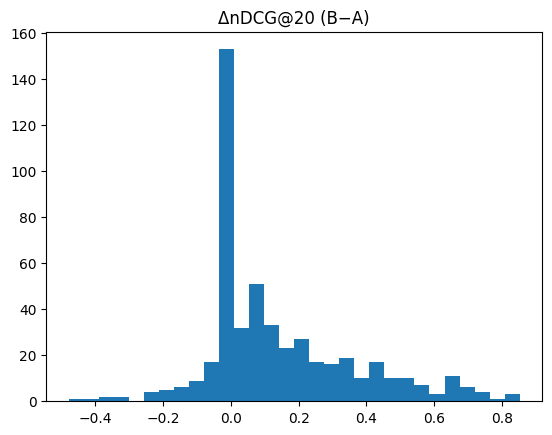

In [ ]:
delta = joined["ndcg@k_B"]-joined["ndcg@k_A"]
plt.hist(delta,bins=30)
plt.title("ΔnDCG@20 (B−A)")
plt.show()